### Cifar-10 이미지 분류 - v2
- 데이터 부풀리기


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터전처리

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 12s 0us/step


In [3]:
# X_data : scaling
X_train = X_train / 255.
X_test = X_test / 255.

In [4]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

- 모델 정의/설정

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same',activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

In [7]:
model.compile(
    optimizer=RMSprop(learning_rate = 0.0001, decay=1e-6),
    loss ='categorical_crossentropy',
    metrics = ['accuracy']
)

In [8]:
model_path = 'best-cifar10-v1.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

- 데이터 부풀리기

In [9]:
# valid
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2,
    random_state=seed
)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 10,         # randomly rotate images in the range (deg 0 to 180) width_shift_range=0.1, 
    width_shift_range = 0.1,     # randomly shift images horizontally height_shift_range=0.1, 
    height_shift_range = 0.1,    # randomly shift images vertically
    shear_range = 0.1,           # 도형의 기울기
    zoom_range= [0.8, 1.2],      # set range for random zoom
    horizontal_flip=True,        # randomly flip images 
    vertical_flip=False,         # randomly flip images
    fill_mode='nearest',         # set mode for filling points outside the input boundaries
)


In [11]:
datagen.fit(X_train)

- 데이터 부풀리기를 한 결과로 학습

In [12]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32), 
    validation_data = (X_valid, Y_valid), 
    epochs=100, batch_size=32, 
    callbacks=[mc, es])

Epoch 1/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.8949 - accuracy: 0.3013
Epoch 1: val_loss improved from inf to 1.60240, saving model to best-cifar10-v1.h5
1250/1250 [==============================] - 39s 22ms/step - loss: 1.8946 - accuracy: 0.3014 - val_loss: 1.6024 - val_accuracy: 0.4130
Epoch 2/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.6406 - accuracy: 0.3988
Epoch 2: val_loss improved from 1.60240 to 1.46992, saving model to best-cifar10-v1.h5
1250/1250 [==============================] - 26s 21ms/step - loss: 1.6405 - accuracy: 0.3988 - val_loss: 1.4699 - val_accuracy: 0.4640
Epoch 3/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.5379 - accuracy: 0.4421
Epoch 3: val_loss improved from 1.46992 to 1.38163, saving model to best-cifar10-v1.h5
1250/1250 [==============================] - 25s 20ms/step - loss: 1.5379 - accuracy: 0.4421 - val_loss: 1.3816 - val_accuracy: 0.5010
Epoch 4/100
1250/1250 [==================

In [13]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.7235 - accuracy: 0.7584


[0.7234826683998108, 0.758400022983551]

In [14]:
y_acc1 = hist.history['accuracy']
y_vloss1 = hist.history['val_loss']
xs1 = np.arange(1, len(y_acc1) + 1)

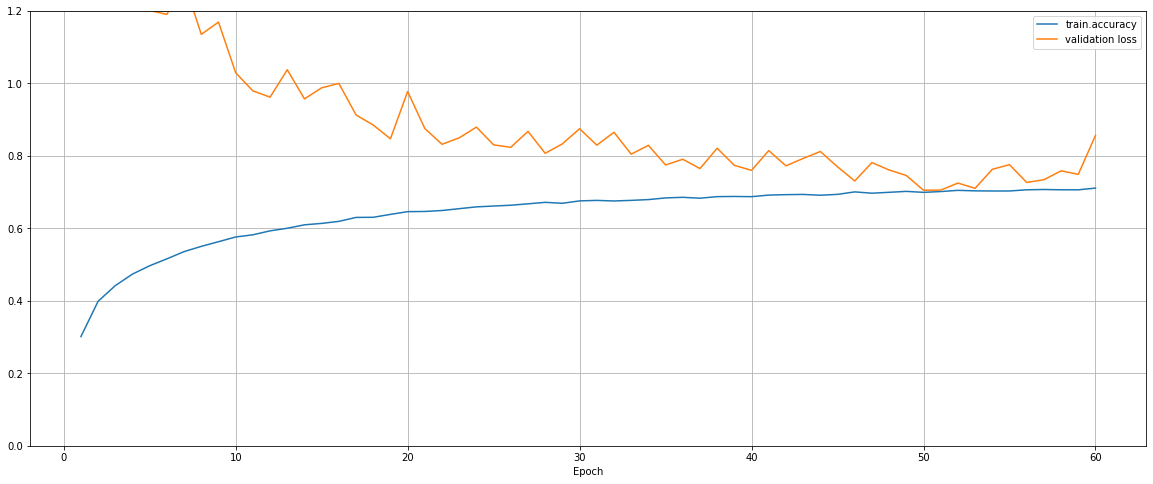

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(xs1, y_acc1, label='train.accuracy')
plt.plot(xs1, y_vloss1, label='validation loss')
plt.legend(), plt.grid()
plt.ylim([0,1.2])
plt.xlabel('Epoch')
plt.show()